In [263]:
import pandas as pd
import numpy as np
from fast_ml.feature_selection import get_constant_features
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from boruta import BorutaPy
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
import os
from datetime import datetime
from joblib import dump, load
import seaborn as sns
import matplotlib.pyplot as plt

NOW_TIME = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
N_JOBS = -1

np.random.seed(42)

## Data loading

In [140]:
X_train = np.genfromtxt('./data/arcene_train.data', delimiter=' ', dtype=int)
y_train = np.genfromtxt('./data/arcene_train.labels', delimiter=' ', dtype=int)

X_test = np.genfromtxt('./data/arcene_valid.data', delimiter=' ', dtype=int)
y_test = np.genfromtxt('./data/arcene_valid.labels', delimiter=' ', dtype=int)

## Explore the data

In [141]:
# dataset has constant features
X_train_df = pd.DataFrame(X_train)
constant_feats = get_constant_features(X_train_df)
constant_feats.head()

,Desc,Var,Value,Perc
0,Constant,113,0,100.0
1,Constant,143,0,100.0
2,Constant,6995,0,100.0
3,Constant,6866,0,100.0
4,Constant,6346,0,100.0


In [142]:
# no missing values
assert(np.all(X_train_df != "?"))
assert(np.all(X_train_df != np.NaN))
assert(np.all(X_train_df != " "))
assert(np.all(X_train_df != ""))

## Needed functions

Below I attach all funcstions I used to develop my solution. AIn the next section I describe my methodology.

In [143]:
def tune_model(X_train, y_train, pipe, hyperparams):
    rscv = GridSearchCV(pipe, hyperparams, verbose=3, cv = 3)
    rscv.fit(X_train, y_train)

    return rscv

In [144]:
def get_number_of_selected_features(estimator: Pipeline):

    step_names = [step[0] for step in estimator.steps]

    for step_name in step_names:
        if(step_name[-2:] == "fs"):
            last_feature_selector_name = step_name
        if(step_name[-2:] == "fe"):
            break
    last_feature_selector = estimator.steps[step_names.index(last_feature_selector_name)][1]

    if last_feature_selector_name == "boruta_fs":
        return last_feature_selector.n_features_

    is_feature_selected =  last_feature_selector.get_support().astype(int)
    m = np.sum(is_feature_selected)

    return m

In [145]:
def get_number_of_classifier_input_features(estimator: Pipeline):

    step_names = [step[0] for step in estimator.steps]
    last_feature_selorex_name = \
        [step_name for step_name in step_names if ((step_name[-2:] == "fs") or (step_name[-2:] == "fe"))][-1]
    last_feature_selorex = estimator.steps[step_names.index(last_feature_selorex_name)][1]

    if last_feature_selorex_name == "boruta_fs":
        return last_feature_selorex.n_features_
    elif last_feature_selorex_name =="pca_fe":
        return last_feature_selorex.n_components_

    is_feature_selected = last_feature_selorex.get_support().astype(int)
    m = np.sum(is_feature_selected)

    return m

In [146]:
def get_model_name(pipe: Pipeline) -> str:

    step_names = [step[0] for step in pipe.steps]
    return '-'.join(step_names)

In [147]:
def append_results(model: GridSearchCV, test_acc):
    if not os.path.exists("./resutls"):
        os.makedirs("./resutls")

    with open(f"./resutls/results_{NOW_TIME}.txt", "a") as res_file:
        res_file.write(f"{get_model_name(model.best_estimator_)},{test_acc},{get_number_of_selected_features(model.best_estimator_)},{get_number_of_classifier_input_features(model.best_estimator_)}\n")

In [148]:
def serialize_model(model: GridSearchCV):
    if not os.path.exists("./models"):
        os.makedirs("./models")
    dump( model, os.path.join("./models", get_model_name(model.best_estimator_)) )

In [149]:
def deserialize_model(model_name: str) -> GridSearchCV:
    return load( os.path.join("./models", model_name) )

In [150]:
def tune_test_save(X_train, y_train, X_test, y_test, pipe: Pipeline, hyperparams):
    model = tune_model(X_train, y_train, pipe, hyperparams)
    test_acc = (model.predict(X_test) == y_test).mean()
    append_results(model, test_acc)
    serialize_model(model)
    return model

In [189]:
def test_all(pipes_hyperparams):
    for pipe, hyperparams in pipes_hyperparams:
        print (f"\n\n\t=============== {get_model_name(pipe)} ===============\n" )
        tune_test_save(X_train, y_train, X_test, y_test, pipe, hyperparams)

## Building classification pipelines

My aim was to compare different feature selection methods. 

I tested several feature selection approaches and two classififers: Random Forest and GradientBoosting, as they usually perform quite well and are not very time consuming. Of course, to compare feature selection methods, we should analyze their performances with the same classifier. That is why, I suggest examinig the results for RF and GB separately. Anyway, it is also interesting how different classifiers work with certain feature selection methods (and that is why I decied to test them with two classifiers instead of just one).

Below I build model pipelines. Each pipeline consist of various feature selection algorithms. Firstly, I remove constant variabels and scale the data. Then, I applay different feature selection methods and feature extraction (like PCA) as weell. Finallly, I use RF or GB classifiers to classify transformed data. 
Hyperparameters of all pipes are tuned with the grid search crosss validation.

Feature selection methods I use:
* no feature selection (reference point)
* KBest witth ANOVA tests
* KBest with mutual information 
* PCA (rather feature extraction that selection, but interesting to compare)
* Boruta + PCA
* Boruta only
* Selection based on coefficient of Logistic Regression with L1 regularization
* Selection based on coefficient of Logistic Regression with L2 regularization

In [241]:
classifier_pipe_step = ('rf', RandomForestClassifier())
classifier_hyperparams = {
   'rf__n_estimators': [20, 50, 100, 200],
   'rf__max_depth': [None, 2, 5, 10] 
}

# classifier_pipe_step = ('gb', GradientBoostingClassifier())
# classifier_hyperparams = {
#     'gb__n_estimators': [20, 50, 100],
#     'gb__learning_rate': [0.01, 0.1, 1],
#     'gb__max_depth': [2, 3, 5]
# }

pipes_hyperparams = [
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            classifier_pipe_step
        ]),
        dict
        (
            { },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('kbest_fs', SelectKBest()),
            classifier_pipe_step
        ]),
        dict
        (
            { 
                'kbest_fs__k': [10, 15, 30, 100, 300, 3000]
            },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('kbest_mi_fs', SelectKBest(mutual_info_classif)),
            classifier_pipe_step
        ]),
        dict
        (
            { 
                'kbest_mi_fs__k': [10, 15, 30, 100, 300, 3000]
            },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('pca_fe', PCA()),
            classifier_pipe_step
        ]),
        dict
        (
            { 
                'pca_fe__n_components': [0.7, 0.8, 0.9, 0.99]
            },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('boruta_fs', BorutaPy(RandomForestClassifier(n_estimators=200, n_jobs=N_JOBS, class_weight='balanced', max_depth=6), n_estimators='auto', verbose=2)),
            ('pca_fe', PCA()),
            classifier_pipe_step
        ]),
        dict
        (
            { 
                'pca_fe__n_components': [0.7, 0.8, 0.9, 0.99]
            },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('boruta_fs', BorutaPy(RandomForestClassifier(n_estimators=200, n_jobs=N_JOBS, class_weight='balanced', max_depth=6), n_estimators='auto', verbose=2)),
            classifier_pipe_step
        ]),
        dict
        (
            { },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('logregl1_fs', SelectFromModel(None)),
            classifier_pipe_step
        ]),
        dict
        (
            { 
                'logregl1_fs__estimator': [
                    LogisticRegression(penalty="l1", solver="liblinear", C=0.1),
                    LogisticRegression(penalty="l1", solver="liblinear", C=1),
                    LogisticRegression(penalty="l1", solver="liblinear", C=3),
                    LogisticRegression(penalty="l1", solver="liblinear", C=10)
                ],
            },
            **classifier_hyperparams
        )
    ),
    (
        Pipeline
        ([
            ('variance_trh_fs', VarianceThreshold()),
            ('scaller', StandardScaler()),
            ('logregl2_fs', SelectFromModel(None)),
            classifier_pipe_step
        ]),
        dict
        (
            { 
                'logregl2_fs__estimator': [
                    LogisticRegression(penalty="l2", C=0.1),
                    LogisticRegression(penalty="l2", C=1),
                    LogisticRegression(penalty="l2", C=3),
                    LogisticRegression(penalty="l2", C=10)
                ],
            },
            **classifier_hyperparams
        )
    ),

]

In [ ]:
test_all(pipes_hyperparams)

## Results analysis

In my analysis, I consider accuracy of the pipelines and the number of selected features. Two approaches reagrding the number of selected features can be considered. Firstly, one can focus on taking the least number of features from the input trainning data (the most common case, for example in medicine, where we want the smallest amout of infomration about patients to make decisions, as the medical examinations - features - are usually expensive and time consuming). The second approach could be to define the smallest possible numbner of features as the input for the final classifer (question of performance of the classifier or simpler classification analysis). In the first case, feature extraction methodss, like PCA does not reduce the number of features (they always need all features to define principal components and reduce the data dimension), but in the second case they are helpful. 

That is why, I consider two feature metrics - Number of features choosen from the initial dataset and Number of features that are the input for the final classifier. In the case I dont use any feature extraction methods, like PCA, the metrics are the same. 

In [279]:
results = pd.read_csv("./resutls/results_17-05-2022_02-27-05.txt", header=None)
results.columns = ["model", "Accuracy on the test set", "Number of features choosen from the initial dataset", "Number of features that are the input for the final classifier"]

In [280]:
results = results.sort_values(by="Accuracy on the test set", ascending=False)
results

,model,Accuracy on the test set,Number of features choosen from the initial dataset,Number of features that are the input for the final classifier
5,variance_trh_fs-scaller-kbest_mi_fs-rf,0.79,15,15
7,variance_trh_fs-scaller-logregl2_fs-rf,0.79,4119,4119
10,variance_trh_fs-scaller-pca_fe-gb,0.78,9920,24
6,variance_trh_fs-scaller-logregl1_fs-rf,0.77,145,145
2,variance_trh_fs-scaller-rf,0.75,9920,9920
4,variance_trh_fs-scaller-pca_fe-rf,0.75,9920,42
1,variance_trh_fs-scaller-boruta_fs-rf,0.74,22,22
3,variance_trh_fs-scaller-kbest_fs-rf,0.72,300,300
8,variance_trh_fs-scaller-gb,0.71,9920,9920
12,variance_trh_fs-scaller-logregl2_fs-gb,0.69,4084,4084


Text(0, 0.5, '')

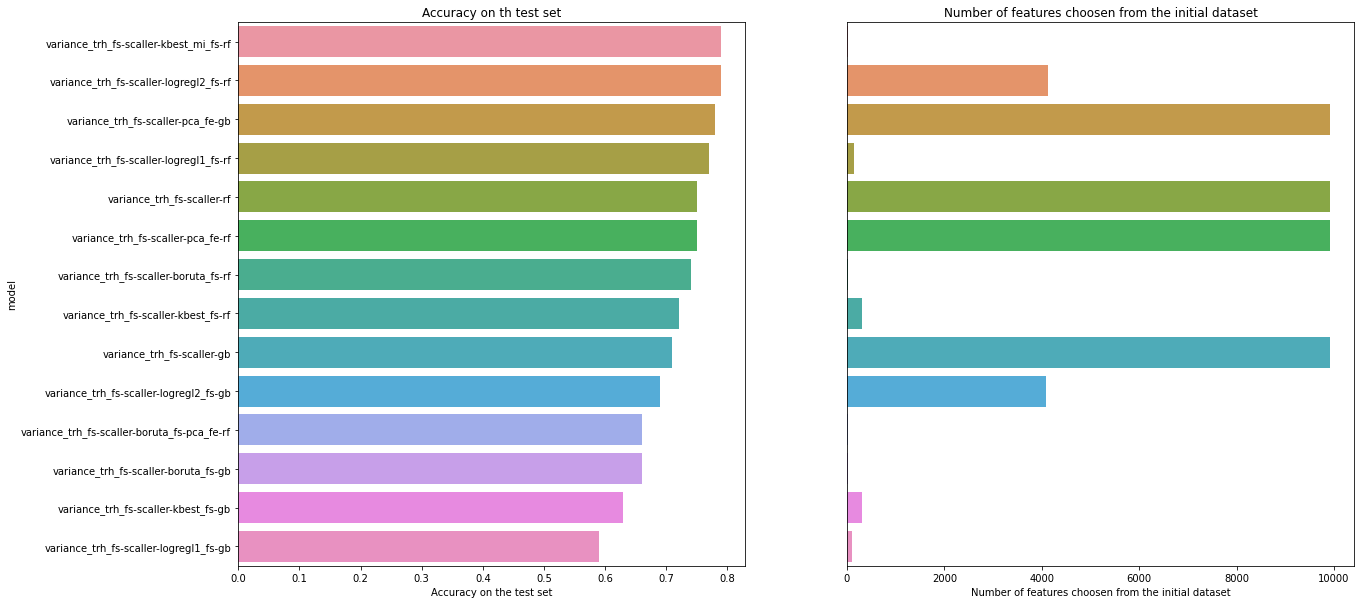

In [281]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1) 

sns.barplot(y="model", x="Accuracy on the test set", data=results, ax=ax)
ax.set_title("Accuracy on th test set")

ax = fig.add_subplot(1, 2, 2) 
sns.barplot(y="model", x="Number of features choosen from the initial dataset", data=results, ax=ax)
ax.set_title("Number of features choosen from the initial dataset")
ax.set_yticks([])
ax.set_ylabel(None)

Text(0, 0.5, '')

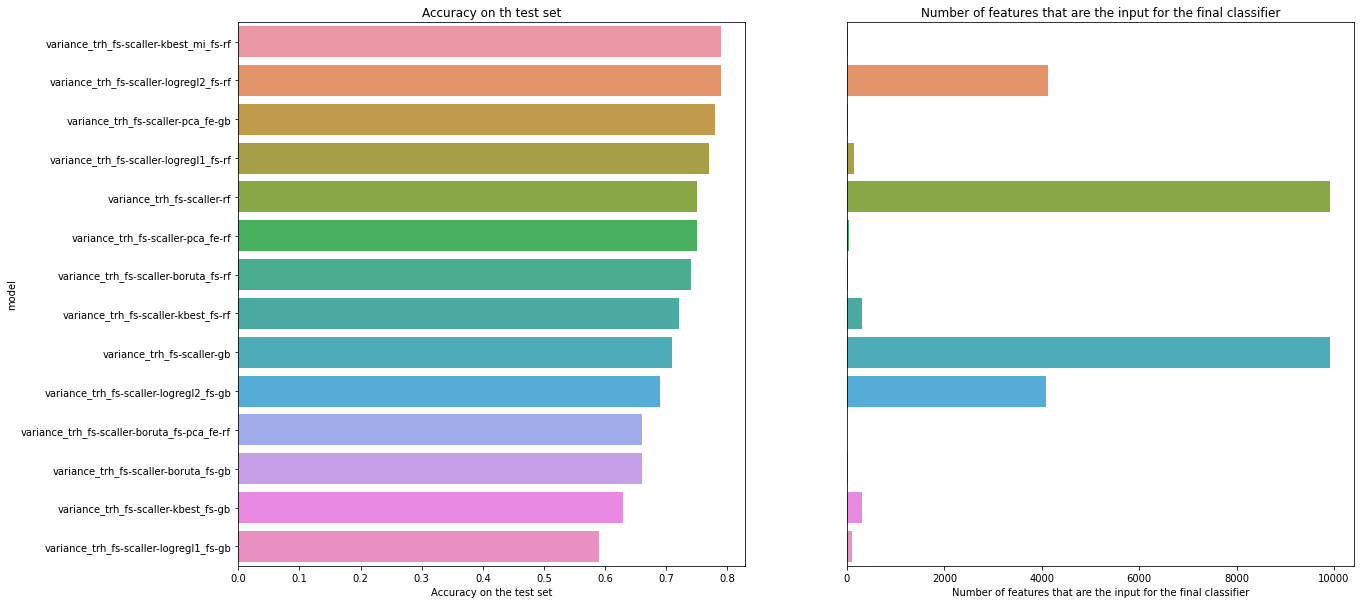

In [283]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1) 

sns.barplot(y="model", x="Accuracy on the test set", data=results, ax=ax)
ax.set_title("Accuracy on th test set")

ax = fig.add_subplot(1, 2, 2) 
sns.barplot(y="model", x="Number of features that are the input for the final classifier", data=results, ax=ax)
ax.set_title("Number of features that are the input for the final classifier")
ax.set_yticks([])
ax.set_ylabel(None)

Above plot and table shows that the best accuracy was achieved in the case of simple Kbest feture selection based on mutual information with random forest. Surprisingly, the algorithm needed only 15 featues. Also Logisitic regression with L2 norm performed very well, but it needed quite a lot of features. An interesting thing is the compariosn between L1 and L2 regularization logistic regression feature selection. We can see that L1 log reg chooses far less features than L2 and achives similar accuracy. It is an expected result, since L1 regulartization shrinks the coeficients to 0, while L2 makes them small but ususaly not zero. Hence it is easier for L1 reguarlized Logistic regression to reject features. 

Applying only PCA also works quite well (for both classifiers), but if we consider the Number of features choosen from the initial dataset, it takes all of them. For Number of features that are the input for the final classifier  however the number is really small (almost 10k vs 24  for GB classifier).

Netx, we have boruta feature selection which also gives satisfactory results. However, it is very time consuming, since a lot of iterations are needed to slect all important features (and as a result - multiple fitting of the boruta estimator). 

Lastly, above plots shows that random forest usually worked significantly better than gradient boosting. It can be caused by the fact that Gradient boosting is more demanding to tune its hyperparameters. 
